In [8]:
suppressMessages(library(tidyr))
suppressMessages(library(dplyr))
suppressMessages(library(pheatmap))
suppressMessages(library(ggplot2))
suppressMessages(library(patchwork))
suppressMessages(library(ggtree))
suppressMessages(library(hash))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(ggalluvial))
suppressMessages(library(grid))
suppressMessages(library(ggrepel))
suppressMessages(library(ggdark))
suppressMessages(library(tidyverse))
suppressMessages(library(ggrastr))
suppressMessages(library(ggpubr))
suppressMessages(library(readxl))
suppressMessages(library(ggsci))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(circlize))
suppressMessages(library(aplot))
suppressMessages(library(Seurat))
suppressMessages(library(gridExtra))
library(wesanderson)
#library(showtext)

Figure 4A

In [9]:
dataF <- readRDS("/data/work/FinallyPlot/Statbarplot/Cell2loc_Filter_new.rds")
level <- c("GF_cecum","GF_colon","GF_iluem1","GF_ileum2","SPF_cecum","SPF_colon","SPF_ileum2","SPF_ileum3")
dataF$batch <- factor(dataF$batch,levels = 0:7,labels = level)

In [19]:
Trans <- read.csv("/data/work/08_plot/cell2loc_NewID.txt",sep = "\t")
head(Trans)
Trans$NewID <- as.numeric(Trans$NewID)
celltypes_levels  <- Trans$Name
dataF$celltypes <- factor(dataF$celltypes,levels = celltypes_levels)
legend.title.size = 25
legend.text.size = 18
plot.title.size = 30
pt.size = 0.05
title <- "Neighbourhood"
mycolor <- c("#F2F318","#B3823E","#009FFF","lightblue","#90AD1C","cyan","#FF00B6","#F7E1A0","purple","red","#F8A19F",
              "green","blue","#766C95")
names(mycolor) <- celltypes_levels
plst <- list()
show <- c("GF_iluem1","GF_ileum2","SPF_ileum2","SPF_ileum3","GF_colon","SPF_colon","GF_cecum","SPF_cecum")
for(i in show){
  print(i)
  data <- dataF %>% filter(batch == i)
  p <- ggplot(data,aes_string(x = 'x',y = 'y',color = "celltypes")) + 
      geom_point(shape = 19, size = pt.size,position = position_jitter(width=0, height=0))+theme_void()+
      theme(axis.text = element_blank(), axis.ticks = element_blank(), panel.grid = element_blank(),
        axis.title = element_blank(), axis.line = element_blank(), legend.position = 'right') +
      theme(legend.title = element_text(size = legend.title.size,family = "Times",face = "bold"))+
      theme(legend.text = element_text(size = legend.text.size,family = "Times",face = "bold")) +
      theme(plot.margin = unit(c(1,0.5,1,0.5),"cm")) + 
      ggtitle(i) + scale_color_manual(values=mycolor)+
      theme(plot.title = element_text(size = plot.title.size,family = "Times",
                                      face = "bold",hjust = 0.5)) + 
      guides(color = guide_legend(override.aes = list(size=5))) # + facet_wrap( ~ batch,ncol = 4,scales = "free") +
      theme(strip.background = element_blank(),strip.text = element_text(face = "bold",size = 20)) 
   
   if(grepl("colon",i)){
       pl <- p + annotate("segment",x = max(data$x), xend = max(data$x) - 1000,color = "black",
                      y = min(data$y)-100,yend = min(data$y)-100,size = 1)
       plst[[i]] <- pl + annotate("text",x = max(data$x) - 1000,y = min(data$y)-260,
                                  size = 7,color = "black",
                                label = "500 μm",vjust = 0.5,hjust = 0.5)
   }else{
       pl <- p + annotate("segment",x = max(data$x), xend = max(data$x) - 400,color = "black",
                      y = min(data$y)-100,yend = min(data$y)-100,size = 1)
       plst[[i]] <- pl + annotate("text",x = max(data$x) - 400,y = min(data$y)-260,size = 7,
                                  color = "black",
                                label = "200 μm",vjust = 0.5,hjust = 0.4)
   }
   if(length(unique(data$celltypes)) != length(unique(dataF$celltypes))){
      plst[[i]] <- plst[[i]] + NoLegend()
  }
 
}
    

,Name,NewID
,<chr>,<int>
1,Apoa4 high mature epithelial,0
2,Saa1 high mature epithelial,1
3,Hmgcs2 high mature epithelial,2
4,Camk1d high mature epithelial,3
5,Antibacterial niche,4
6,Stem cell niche,5


[1] "GF_iluem1"
[1] "GF_ileum2"
[1] "SPF_ileum2"
[1] "SPF_ileum3"
[1] "GF_colon"
[1] "SPF_colon"
[1] "GF_cecum"
[1] "SPF_cecum"


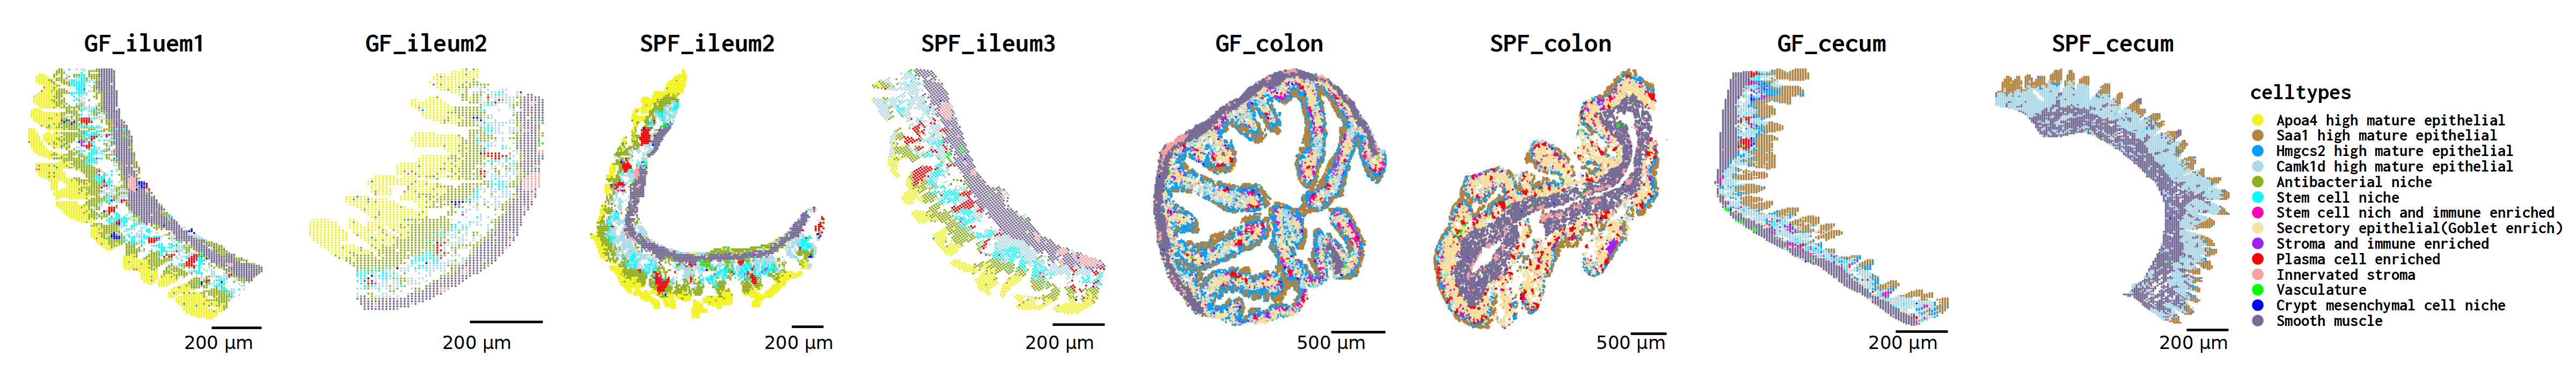

In [20]:
# x axis # 
options(repr.plot.width = 40,repr.plot.height=6)
p <-  wrap_plots(plst,ncol=8) + plot_layout(guides = 'collect') 
p

Figure 4B

In [156]:
### Cell2ClusterHeatmap ###
Cell2ClusterHeatmap <- function(data,hm_columns,tree_columns,var,title,ax.tx.size =20,ax.tl.size=25,
                                tree_plot = TRUE,yaxis = NULL,yaxis.rev = TRUE,xaxis = NULL,xaixs.rev = TRUE){
  # hm_dat #
  hm_dat <- data[,hm_columns]
  hm_dat <- gather(hm_dat,celltypes,scores,-c(var))
  hm_dat$scores <- log2(hm_dat$scores) # log10 == log2 yes!
  hm_dat$scores <-as.vector(scale(hm_dat$scores, center = T, scale = T))
  # tree_dat #
  tree_dat<-spread(hm_dat,celltypes,scores)
  rownames(tree_dat) <- tree_dat[,var]
  tree_dat <- tree_dat[,tree_columns]
  # heatmap #
  if(!is.null(yaxis)){
    if(yaxis.rev){
        hm_dat$celltypes <- factor(hm_dat$celltypes,levels = rev(xaxis))
    } else{
        hm_dat$celltypes <- factor(hm_dat$celltypes,levels = xaxis)
    }
  }
  if(!is.null(xaxis)){
    if(xaixs.rev){
        hm_dat[,var]<- factor(hm_dat[,var],levels = rev(yaxis))
    } else {
        hm_dat[,var]<- factor(hm_dat[,var],levels = yaxis)
    }
  }
  p <- ggplot(hm_dat,aes_string(x = "celltypes",y = var,fill = "scores")) + geom_tile() +  ggtitle(title) +  # geom_raster() + 
    theme(axis.text.x = element_text(angle = 45,vjust = 1,hjust = 1,size = ax.tx.size,family = "Times",face = "bold", 
                                     margin = margin(5,0,0,0)), 
          axis.text.y = element_text(size = ax.tx.size,family = "Times",face = "bold", 
                                     margin = margin(0,5,0,0)),
          axis.title= element_blank(),
          axis.line = element_line(linetype = 1,color= "black",size = 1),
          legend.text = element_text(size = 20,family = "Times",face = "bold"),
          legend.title = element_text(size = 25,family = "Times",face = "bold"),
          axis.ticks  = element_line(color = "black",size = 1,lineend = 2),
          plot.title = element_text(size = 30,family = "Times",face = "bold",vjust = 0.5,hjust= 0.5),
          plot.margin = unit(c(1,0.5,1,0.5),"cm"))  + 
    scale_fill_gradient2(high =  "red",mid = "white", low = "blue",midpoint = 0) + labs(fill = "log2(Scores)") 
  if(tree_plot){
    # tree plot #
    p2 <- ggtree(hclust(dist(tree_dat))) + labs(y = "region_cluster") + 
      theme(axis.title.y= element_text(size = ax.tl.size,family = "Times",face = "bold",margin = margin(0,5,0,0)))  # + geom_tiplab()
    p3 <- ggtree(hclust(dist(t(tree_dat)))) + labs(y = "Celltypes") + 
      theme(axis.title.x= element_text(size = ax.tl.size,family = "Times",face = "bold",margin = margin(5,0,0,0))) + 
      coord_flip() 
    # joint #
    p.me <- p %>% insert_left(p2,width = 0.1) %>% insert_bottom(p3,height = 0.4)  
  }
  else {
    p.me <- p
  }
  return(p.me)
}
GetCell2ClusterAvgScore <- function(dat,var,hm_index = c(13:66,69)){
  hm_dat <- dat[,hm_index]
  mat_index <- seq(1:(length(colnames(hm_dat))-1))
  avg_score <- aggregate(hm_dat[,mat_index],by = list(cluster = hm_dat[,var]),FUN = "mean")
  rownames(avg_score) <- avg_score$cluster
  avg_score <- avg_score[,-1]
  score <- apply(avg_score,MARGIN = 2,FUN = function(x){
    x / sum(x)
  })
  score <- as.data.frame(score)
  score$cluster <- rownames(score)
  return(score)
}
date() 

[1] "Fri Jan 10 11:02:35 2025"

In [157]:
xaxis <- c('EC (Apoa4 high)','EC (Car1 high)','EC (Saa1 high)','EC (Hmgcs2 high)','EC (Cmss1 high)','EC (Reg3g high)',
           'EC (Olfm4 high)','Goblet1','Goblet2','Paneth','Fibroblast(Adamdec1 high)','Monocyte','cDC1','IgA plasma',
           'Enteroendocrine','Mesothelial cell','Terminal glial cell','Endothelial','Fibroblast(Sox6 high)','SMC','Tuft',
           'mLTo','Fibroblast','cDC cycling','B cycling','Plasma cycling','Il6+ Macrophage','Gpnmb+ Macrophage',
           'Mmp13+ Macrophage','Fgl2+ Cd8 Trm','Neutrophil','LEC','Migratory cDC','BC1','T cycling','IgG plasma',
           'Lyve1+ Macrophage','Mast','ILC2','Activated T','Sell + CD8 T','Tfh','BC3','BC2','Sell+ CD4 T','BC4','pDC',
           'NK','NKT','ILC3','Foxp3+ Treg','gamadelta T','Ifng+ CD8 Trm','Th17')
yaxis <- c('Apoa4 high mature epithelial','Saa1 high mature epithelial','Hmgcs2 high mature epithelial',
           'Camk1d high mature epithelial','Antibacterial niche','Stem cell niche','Stem cell nich and immune enriched',
           'Secretory epithelial(Goblet enrich)','Stroma and immune enriched','Plasma cell enriched',
           'Innervated stroma','Vasculature','Crypt mesenchymal cell niche','Smooth muscle')
col_names <- colnames(dataF)
hm_NC_index <- col_names[c(12:65,69)]
tree_NC_index <- col_names[c(12:65)]
NC_score <- GetCell2ClusterAvgScore(dat = dataF,var = "celltypes",hm_index = hm_NC_index)
p_index <- c(tree_NC_index,"cluster")
p <- Cell2ClusterHeatmap(data = NC_score,hm_columns = p_index,var = "cluster",
                         tree_columns = tree_NC_index,
                         title = "Neighbourhood",tree_plot = FALSE,
                         yaxis = yaxis,yaxis.rev = F,xaxis = xaxis,ax.tx.size = 20)

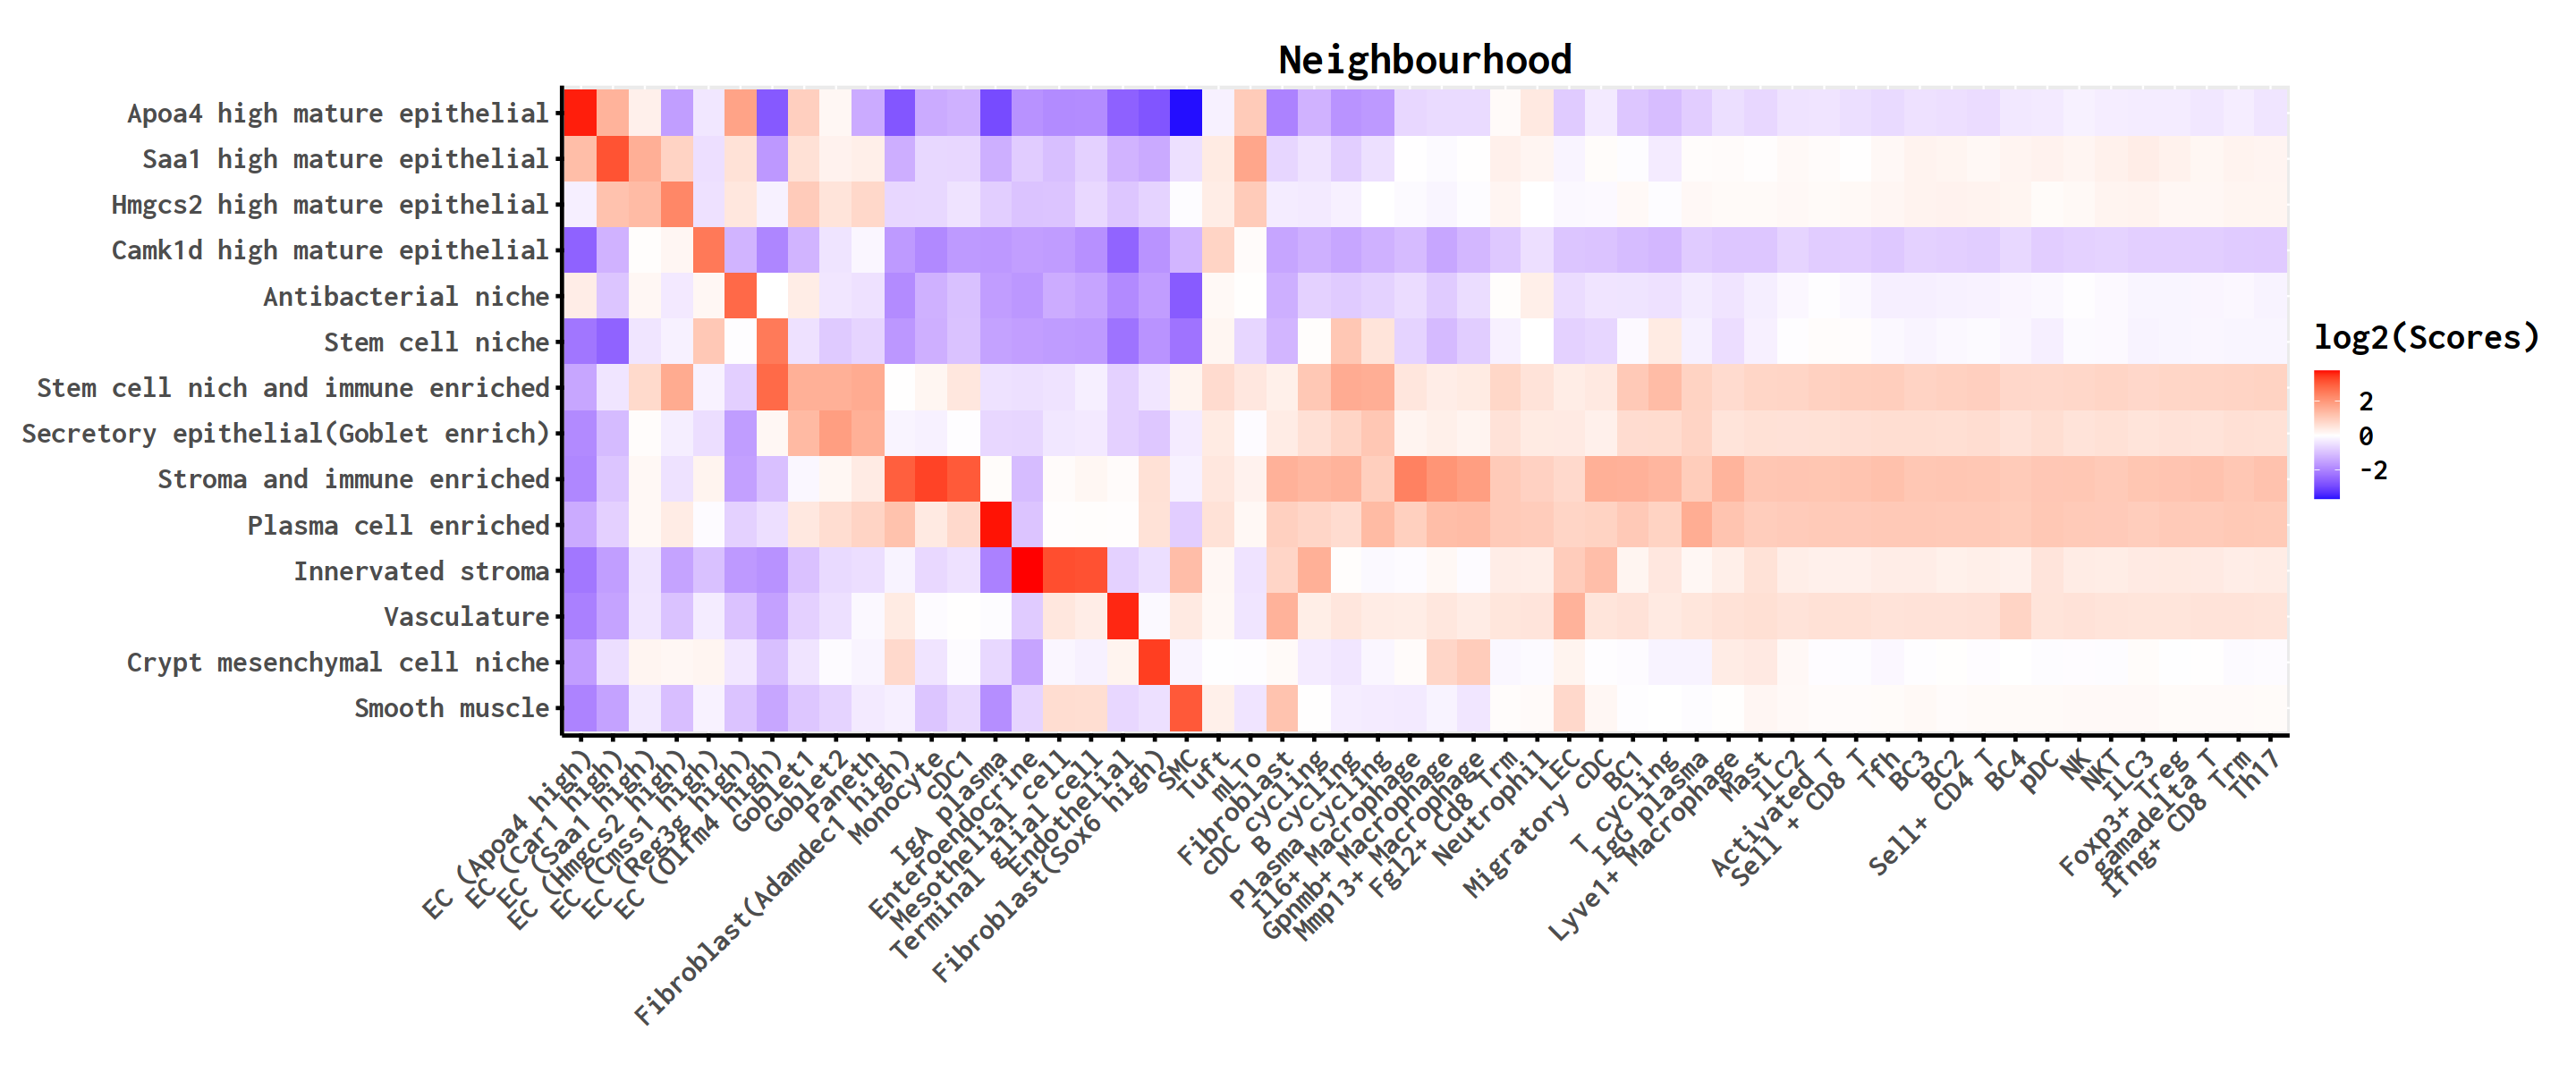

In [158]:
options(repr.plot.width = 24,repr.plot.height= 10)
p

Figure 4C

In [23]:
CellRadioPlot_custom <- function(data,index,title,mycolor = NULL,levels = NULL,legend = TRUE){
    CellNum2 <- data[,index]
    colnames(CellNum2) <- c("GF","SPF")
    CellNum.p <- as.data.frame(proportions(as.matrix(CellNum2),margin = 2) * 100)
    print(head(CellNum.p))
    CellNum.p$celltypes <- rownames(CellNum.p)
    CellNum.pt <- melt(CellNum.p,id.vars= "celltypes")
    colnames(CellNum.pt) <- c("celltypes","variable","Composition")
    if(!is.null(levels)){
            CellNum.pt$celltypes <- factor(CellNum.pt$celltypes,levels = levels)  # celltype  levels color  
    } else {
        print('No level!')
    }
    if(is.null(mycolor)){
        nclu <- length(rownames(CellNum.p))
        mycolor = colorRampPalette(brewer.pal(9, "Set1"))(nclu)
    } else {
        print(mycolor)
     }
    p <- ggplot(CellNum.pt,aes(x = variable,y = Composition,fill= celltypes,stratum = celltypes,alluvium = celltypes)) + 
                geom_col(width = 0.3,color= "black") + ggtitle(title) + 
                    geom_flow(width = 0.3,alpha = 0.4, knot.pos=0.5) + theme_classic() + labs(x = " " , y = "Composition (%)") +  

            scale_fill_manual(values=mycolor) + theme(
            axis.text.y = element_text(size = 20,face = "bold",margin  = margin(0,10,0,0)),
            axis.text.x = element_text(size = 20,face = "bold",margin  = margin(10,0,0,0)),
            axis.title.x= element_text(size = 25,face = "bold",margin  = margin(15,0,0,0)),
            axis.title.y= element_text(size = 25,face = "bold",margin  = margin(0,15,0,0)),
             axis.line = element_line(linetype = 1,color= "black",size = 1),
            legend.text = element_text(size = 18,face = "bold"),
            legend.title = element_text(size = 25,face = "bold"),
            plot.margin =  unit(c(2,0,0,0),"cm"), # lwm 2023 -7 - 7 
            axis.ticks  = element_line(color = "black",size = 1,lineend = 2),
            plot.title = element_text(hjust = 0.5,size = 30,face = "bold"))
    if(is.null(legend)){
       p <- p + NoLegend()   
    }
    
    return(p)
} 

In [24]:
Cell2loc <- readRDS("/data/work/FinallyPlot/Statbarplot/Cell2loc_Filter_new.rds")
data <- Cell2loc %>% select(batch,celltypes)
subcelltypes <- c("Apoa4 high mature epithelial",
                  "Saa1 high mature epithelial",
                  "Hmgcs2 high mature epithelial",
                  "Camk1d high mature epithelial",
                  "Antibacterial niche",
                  "Stem cell niche",
                  "Stem cell nich and immune enriched",
                  "Secretory epithelial(Goblet enrich)")
index <- data$celltype %in% subcelltypes 
dataF <- subset(data,subset = index)
stat <- as.data.frame.array(table(dataF$celltypes,dataF$batch))
colnames(stat) <- c("GF_cecum","GF_colon","GF_ileum1","GF_ileum2",
                    "SPF_cecum","SPF_colon","SPF_ileum2","SPF_ileum3")
stat <- stat %>% mutate(GF_ileum = GF_ileum1 + GF_ileum2,SPF_ileum = SPF_ileum2 + SPF_ileum3) %>% 
                select(GF_cecum,SPF_cecum,GF_colon,SPF_colon,GF_ileum,SPF_ileum)

In [28]:
mycolor <- c("#F2F318","#B3823E","#009FFF","lightblue","#90AD1C","cyan","#FF00B6","#F7E1A0")

In [29]:
p_cecum <- CellRadioPlot_custom(data = stat,index = c("GF_cecum","SPF_cecum"),title = "cecum",mycolor = mycolor,
               level = subcelltypes)

                                             GF         SPF
Antibacterial niche                  0.03705076  0.06090134
Apoa4 high mature epithelial         0.11115228  0.18270402
Camk1d high mature epithelial       32.30826232 75.18270402
Hmgcs2 high mature epithelial       13.41237495  1.58343484
Saa1 high mature epithelial         42.57132271 22.62484775
Secretory epithelial(Goblet enrich)  3.37161912  0.15225335
[1] "#F2F318"   "#B3823E"   "#009FFF"   "lightblue" "#90AD1C"   "cyan"     
[7] "#FF00B6"   "#F7E1A0"  


Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [30]:
p_colon <- CellRadioPlot_custom(data = stat,index = c("GF_colon","SPF_colon"),title = "colon",mycolor = mycolor,
                          level = subcelltypes,legend = NULL)

                                            GF        SPF
Antibacterial niche                  0.1845018  0.2841806
Apoa4 high mature epithelial         0.1972261  0.3631197
Camk1d high mature epithelial       10.1984985  5.0520998
Hmgcs2 high mature epithelial       27.9552106 12.5828860
Saa1 high mature epithelial         24.7359715 19.5453110
Secretory epithelial(Goblet enrich) 29.0749459 56.3072308
[1] "#F2F318"   "#B3823E"   "#009FFF"   "lightblue" "#90AD1C"   "cyan"     
[7] "#FF00B6"   "#F7E1A0"  


In [31]:
ileum_celltypes <- c("Apoa4 high mature epithelial",
                     "Antibacterial niche",
                     "Saa1 high mature epithelial",
                     "Hmgcs2 high mature epithelial",
                     "Camk1d high mature epithelial",
                     "Stem cell niche",
                     "Stem cell nich and immune enriched",
                     "Secretory epithelial(Goblet enrich)")
ileum_color <- c("#F2F318","#90AD1C","#B3823E","#009FFF","lightblue","cyan","#FF00B6","#F7E1A0")
p_ileum <- CellRadioPlot_custom(data = stat,index = c("GF_ileum","SPF_ileum"),title = "ileum",mycolor = ileum_color,
               level = ileum_celltypes,legend = NULL)

                                            GF        SPF
Antibacterial niche                 37.0072713 29.1628165
Apoa4 high mature epithelial        37.9066207 28.6453521
Camk1d high mature epithelial       14.1216992 28.0354833
Hmgcs2 high mature epithelial        0.4783773  0.1848087
Saa1 high mature epithelial          1.0715653  0.1108852
Secretory epithelial(Goblet enrich)  0.4783773  0.7761966
[1] "#F2F318"   "#90AD1C"   "#B3823E"   "#009FFF"   "lightblue" "cyan"     
[7] "#FF00B6"   "#F7E1A0"  


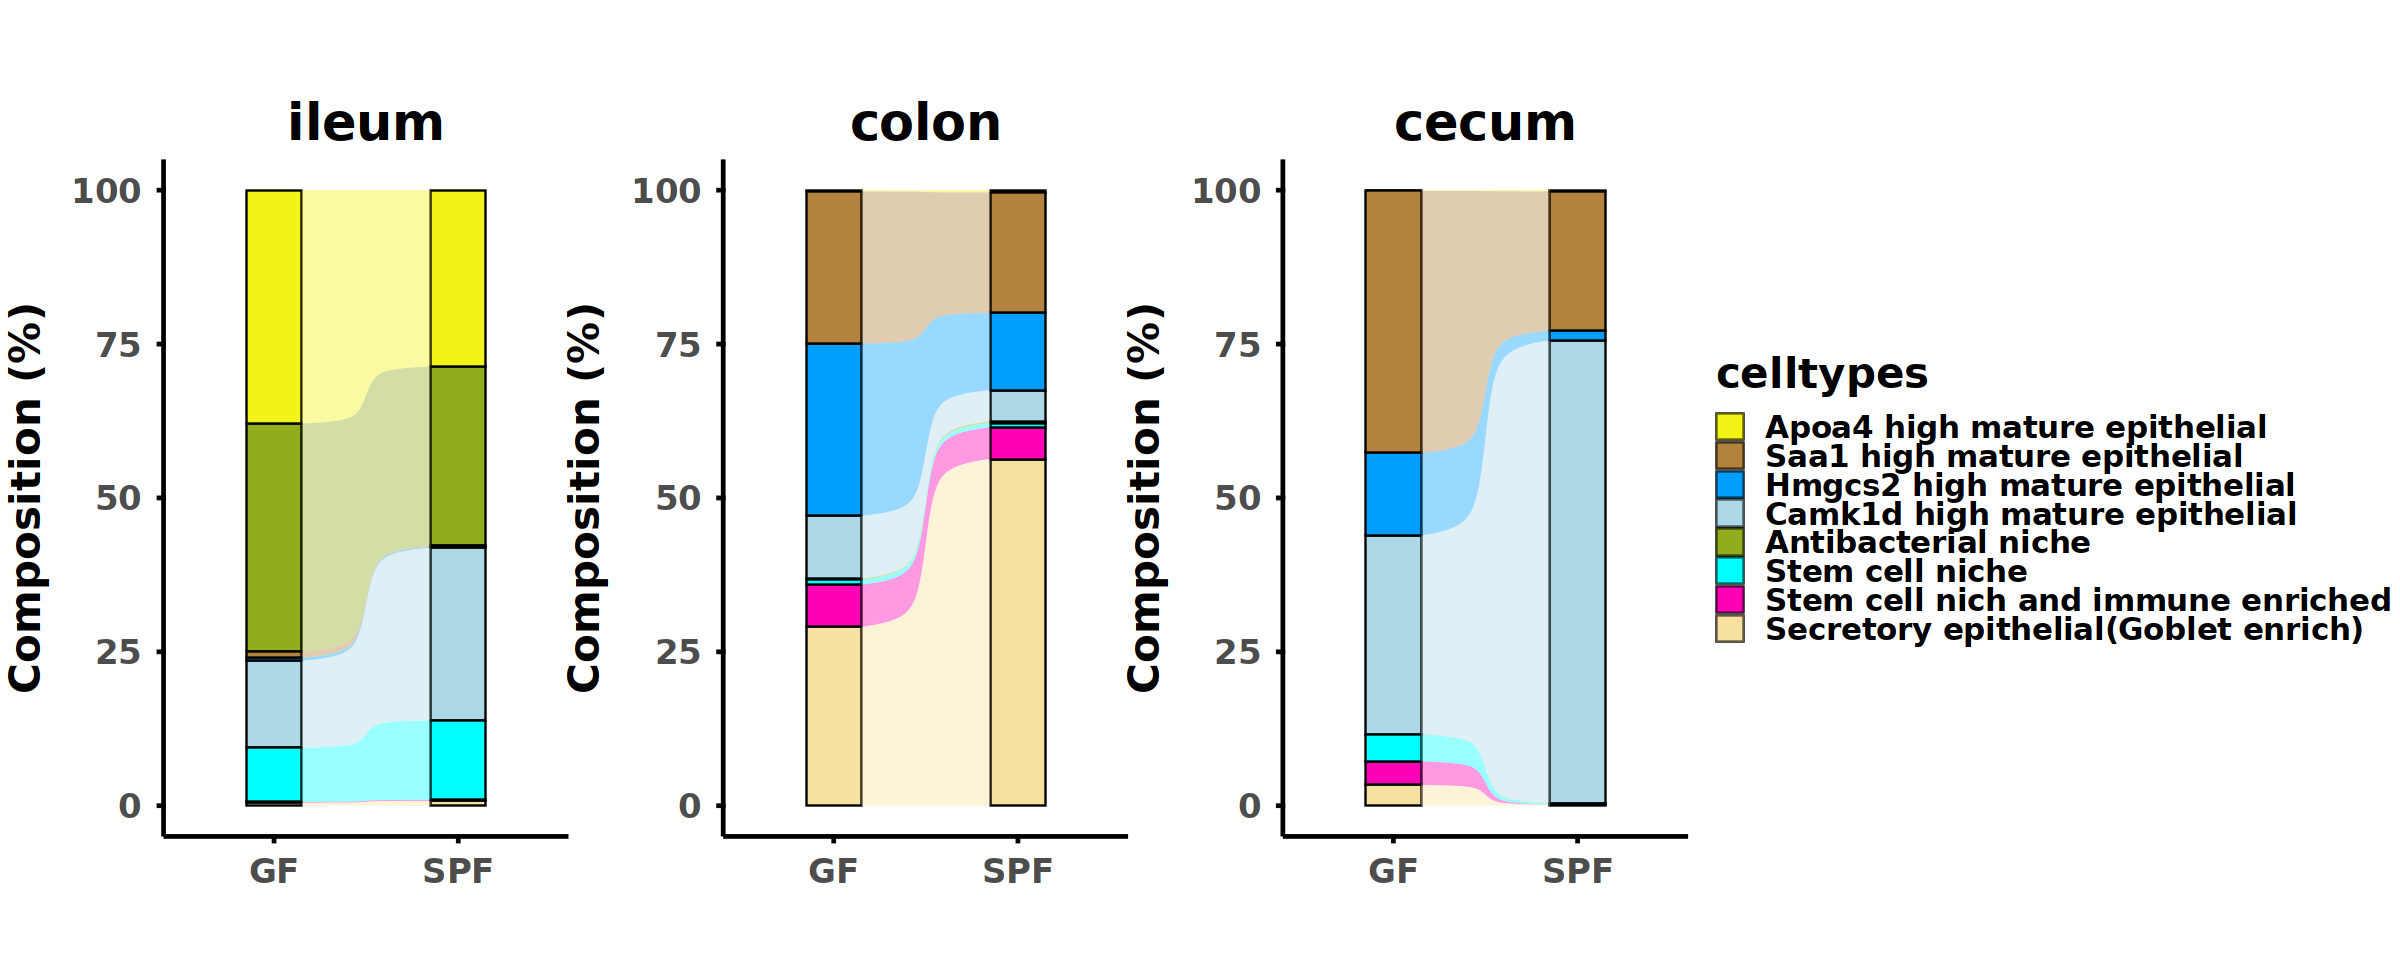

In [32]:
options(repr.plot.width = 20,repr.plot.height= 8)
p <- p_ileum + p_colon + p_cecum + plot_layout(guides = 'collect')
p

Figure 4D

In [ ]:
getdf <- function(df){
  df <- read.delim(df,sep="\t", header = T)
  generatio <- sapply(df$GeneRatio,function(x){eval(str2lang(x))})
  df$generatio <- round(generatio, 3)
  return(df)
}

all_file <- '/Users/dengysh/Work/Projects/SpatialTranscriptomics/GermFreeMiceProject/GetFigures/GOPlots/tissue_GO/Epithelial_DEG_ALL_GO.txt'
df_all <- getdf(all_file)

celist <- c("EC (Car1 high)","EC (Hmgcs2 high)","Goblet1")
colist <- c("EC (Saa1 high)","EC (Cmss1 high)","Goblet2")
illist <- c("EC (Apoa4 high)","EC (Reg3g high)","EC (Olfm4 high)")

co_aph <- paste0(wd,"cecum_EP_EC (Cmss1 high)_GO.txt")
co_csh <- paste0(wd,"cecum_EP_EC (Saa1 high)_GO.txt")
co_gl <- paste0(wd,"cecum_EP_Goblet2_GO.txt")

ce_car1h <- paste0(wd,"colon_EP_EC (Car1 high)_GO.txt")
ce_hch <- paste0(wd,"colon_EP_EC (Hmgcs2 high)_GO.txt")
ce_gl <- paste0(wd,"colon_EP_Goblet1_GO.txt")

il_aph <- paste0(wd,"ileum_EP_EC (Apoa4 high)_GO.txt")
il_omh <- paste0(wd,"ileum_EP_EC (Olfm4 high)_GO.txt")
il_rgh <- paste0(wd,"ileum_EP_EC (Reg3g high)_GO.txt")

ce_car1h <- getdf(ce_car1h)
ce_hch <- getdf(ce_hch)
ce_gl <- getdf(ce_gl)

co_aph <- getdf(co_aph)
co_csh <- getdf(co_csh)
co_gl <- getdf(co_gl)

il_aph <- getdf(il_aph)
il_omh <- getdf(il_omh)
il_rgh <- getdf(il_rgh)

ce_car1h_diff <- ce_car1h %>% arrange(p.adjust) %>% do(head(., n = 10))
ce_hch_diff <- ce_hch %>% arrange(p.adjust) %>% do(head(., n = 10))
ce_gl_diff <- ce_gl  %>% arrange(p.adjust) %>% do(head(., n = 10))

co_aph_diff <- co_aph %>% arrange(p.adjust) %>% do(head(., n = 10))
co_csh_diff <- co_csh %>% arrange(p.adjust) %>% do(head(., n = 10))
co_gl_diff <- co_gl %>% arrange(p.adjust) %>% do(head(., n = 10))

il_aph_diff <- il_aph %>% arrange(p.adjust) %>% do(head(., n = 10))
il_omh_diff <- il_omh %>% arrange(p.adjust) %>% do(head(., n = 10))
il_rgh_diff <- il_rgh %>% arrange(p.adjust) %>% do(head(., n = 10))

df_diff_top10 <- bind_rows(ce_car1h_diff, ce_hch_diff, ce_gl_diff, co_aph_diff, co_csh_diff, co_gl_diff, il_aph_diff, il_omh_diff, il_rgh_diff)

diff_go <- unique(df_diff_top10$ID)
targetct <- c(celist, colist, illist)
df_all_diffgo <- df_all[which(df_all$ID %in% c(diff_go)),] %>% filter(celltypes %in% targetct)

df_diff <- df_all_diffgo %>% mutate(CelltypeGroup = recode(celltypes,
                                            "EC (Cmss1 high)" = "colon_EP_EC (Cmss1 high)",
                                            "EC (Saa1 high)" = "colon_EP_EC (Saa1 high)",
                                            "Goblet2" = "colon_EP_Goblet2",
                                            "EC (Car1 high)" = "cecum_EP_EC (Car1 high)",
                                            "EC (Hmgcs2 high)" = "cecum_EP_EC (Hmgcs2 high)",
                                            "Goblet1" = "cecum_EP_Goblet1",
                                            "EC (Apoa4 high)" = "ileum_EP_EC (Apoa4 high)",
                                            "EC (Olfm4 high)" = "ileum_EP_EC (Olfm4 high)",
                                            "EC (Reg3g high)" = "ileum_EP_EC (Reg3g high)"
                                            ))




df_diff$p.adjust <- round(df_diff$p.adjust,3)
# df_diff_p <- reshape2::dcast(df_diff[,c("ID", "CelltypeGroup", "GeneRatio")], ID~CelltypeGroup, value.var = "GeneRatio")
write.csv(df_diff,"/Users/dengysh/Work/Projects/SpatialTranscriptomics/GermFreeMiceProject/GetFigures/GOPlots/Plots_20230830/df_diff.csv")

df_diff <- df_diff %>% mutate(idct = paste0(ID, CelltypeGroup))

df_rep_index <- df_diff %>% filter(duplicated(idct)) %>% pull(idct)
df_rep <- df_diff %>% filter(idct %in% df_rep_index)
df_uniq <- df_diff %>% filter(!idct %in% df_rep_index)

df_rep_corrt <- NULL
for (i in df_rep_index){
  df_tmp <- df_rep[df_rep$idct==i,] %>% filter(qvalue == max(qvalue))
  df_rep_corrt <- rbind(df_rep_corrt, df_tmp)
}
df_rep_corrt$group <- 2

df_diff_plot_corrected <- rbind(df_rep_corrt, df_uniq)

# df_diff_plot_corrected <- df_diff_plot_corrected %>% mutate(padj_sign = case_when((group == 1 & p.adjust < 0.001) ~ 1,
#                                                                                   (group == 1 & p.adjust < 0.01) ~ 2,
#                                                                                   (group == 1 & p.adjust < 0.1) ~ 3,
#                                                                                   (group == -1 & p.adjust < 0.001) ~ 4,
#                                                                                   (group == -1 & p.adjust < 0.01) ~ 5,
#                                                                                   (group == -1 & p.adjust < 0.1) ~ 6,
#                                                                                   (group == 2 & p.adjust < 0.001) ~ 7,
#                                                                                   (group == 2 & p.adjust < 0.01) ~ 8,
#                                                                                   (group == 2 & p.adjust < 0.1) ~ 9))

df_diff_plot_corrected <- df_diff_plot_corrected %>% mutate(padj_sign = case_when( p.adjust < 0.001 ~ 1,
                                                                                   p.adjust < 0.01 ~ 2,
                                                                                   p.adjust < 0.1 ~ 3))


df_diff_heatmap <- reshape2::dcast(df_diff_plot_corrected[,c("Description", "CelltypeGroup", "padj_sign")], Description~CelltypeGroup, value.var = "padj_sign")
df_diff_heatmap <- df_diff_heatmap %>% tibble::column_to_rownames(var="Description")
df_diff_heatmap[is.na(df_diff_heatmap)] <- 0

P <- reshape2::dcast(df_diff_plot_corrected[,c("Description", "CelltypeGroup", "group")], Description~CelltypeGroup, value.var = "group")
P <- P %>% tibble::column_to_rownames(var="Description")
P[is.na(P)] <- 0

d <- dist(P, method = "euclidean")
fit2 <- hclust(d, method="ward.D")
PB <- P[fit2$order,]

PB <- matrix(ifelse(PB == -1, "↓", ifelse(PB == 1, "↑",ifelse(PB == 2,"→"," "))), nrow(PB))
df_diff_heatmap <- df_diff_heatmap[fit2$order,]

rownames(PB) <- rownames(df_diff_heatmap)
colnames(PB) <- colnames(df_diff_heatmap)
write.csv(PB,"/Users/dengysh/Work/Projects/SpatialTranscriptomics/GermFreeMiceProject/GetFigures/GOPlots/Plots_20230830/df_diff_heatmap.csv")

library(ComplexHeatmap)
library(circlize)
col_fun1 = colorRamp2(c(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), c("lightgray", "#D62728FF","#FF7F0EFF", "#FFBB78FF", "blue", "lightblue", "#c9c1ff", "green", "#09d15a", "#86dda4"))
# cell_fun <- function(j, i, x, y, width, height, fill) {
#   grid.text(PB[i, j], x, y,gp = gpar(fontsize = 15))
# }
arrowcolor <- c("black", "white", "steelblue")
# arrowcolor <- c("red", "blue", "green")
cell_fun <- function(j, i, x, y, width, height, fill) {
  if (PB[i, j] == '↑'){
    grid.text(PB[i, j], x, y,gp = gpar(col = arrowcolor[1], fontsize = 15))
  }else if(PB[i, j] == '↓'){
    grid.text(PB[i, j], x, y,gp = gpar(col = arrowcolor[2], fontsize = 15))
  }else if(PB[i, j] == '→'){
    grid.text(PB[i, j], x, y,gp = gpar(col = arrowcolor[3], fontsize = 15))
  }else{
    grid.text(PB[i, j], x, y,gp = gpar(fontsize = 15))
  }
}

library(showtext)
pdf("/Users/dengysh/Work/Projects/SpatialTranscriptomics/GermFreeMiceProject/GetFigures/GOPlots/Plots_20230830/pheatmap.pdf",width = 40,height = 25)
showtext_begin() 
Heatmap(df_diff_heatmap, 
        col = col_fun1,
        cell_fun = cell_fun,
        rect_gp = gpar(col = "gray", lwd = 0.5),
        column_labels = c("EC (Car1 high)","EC (Hmgcs2 high)","Goblet1","EC (Cmss1 high)","EC (Saa1 high)","Goblet2","EC (Apoa4 high)","EC (Olfm4 high)","EC (Reg3g high)"),
        show_row_names = T,
        row_names_gp = gpar(fontsize = 20),
        column_names_gp = gpar(fontsize = 20),
        row_title = NULL,
        column_title_gp = gpar(fontsize = 20),
        cluster_columns = F,
        cluster_rows = F,
        column_split=rep(c("Cecum","Colon","Ileum"), each = 3),
        border="gray",
        show_row_dend=F,
        show_heatmap_legend = F,
        width = ncol(df_diff_heatmap)*unit(8, "mm"),
        height = nrow(df_diff_heatmap)*unit(8, "mm"))

at1 <- c(0, 1, 2, 3)
lgd1 = Legend(at = at1, labels =c("None","p<0.001","p<0.01","p<0.1"), border="gray",labels_gp = gpar(fontsize = 20), title_gp = gpar(fontsize = 25, fontface = "bold"),
              title = "", legend_gp = gpar(fill = col_fun1(at1)), grid_height = unit(10, "mm"), grid_width = unit(10, "mm"))

# at2 <- c(0, 4, 5, 6)
# lgd2 = Legend(at = at2, labels =c("None","p<0.001","p<0.01","p<0.1"), border="gray",labels_gp = gpar(fontsize = 20), title_gp = gpar(fontsize = 25, fontface = "bold"),
#               title = "Down", legend_gp = gpar(fill = col_fun1(at2)), grid_height = unit(10, "mm"), grid_width = unit(10, "mm"))
# 
# at3 <- c(0, 7, 8, 9)
# lgd3 = Legend(at = at3, labels =c("None","p<0.001","p<0.01","p<0.1"), border="gray",labels_gp = gpar(fontsize = 20), title_gp = gpar(fontsize = 25, fontface = "bold"),
#               title = "Both", legend_gp = gpar(fill = col_fun1(at3)), grid_height = unit(10, "mm"), grid_width = unit(10, "mm"))
# 
at4 <- c("↑","↓","→")
lgd4 = Legend(at = at4, labels = c("All upregulated","All downregulated","50% up, 50% down"), labels_gp = gpar(fontsize = 20),
              type = "points", legend_gp = gpar(col = arrowcolor), title = "", pch = at4, size = 20, background = "lightgray", grid_height = unit(10, "mm"), grid_width = unit(10, "mm"))

# lgd_list_vertical <- packLegend(lgd1, lgd2, lgd3, lgd4, direction = "horizontal")
lgd_list_vertical <- packLegend(lgd1, lgd4, direction = "horizontal")
draw(
  lgd_list_vertical,
  x = unit(0.60, "npc"), 
  y = unit(0.1, "npc"),
)

showtext_end()
dev.off() 

In [ ]:
data <- read.csv("/data/work/intestines/subRDS/Epithelial/DEG/Epithelial_DEG_ALL_GO.txt",sep = "\t")

Figure 4E

In [70]:
# function data# 
getdf <- function(obj){
  aobj <- NULL
  obj <- readRDS(obj)
  aobj[[1]] <- obj@assays$METABOLISM$score
  aobj[[2]] <- obj@meta.data
  return(aobj)
}
# ct : c("EC(Car1 high)","EC(Hmgcs2 high)","Goblet1")
meltdf <- function(obj,ct){
    metabolism <- obj[[1]]
    metadata <- obj[[2]][,c("mice","clusters","celltypes")]
    df <- merge(metadata,t(metabolism),by="row.names")
    df_select <- df %>% filter(celltypes %in% ct)
    df_select$celltypes <- factor(df_select$celltypes, levels=ct)
    return(df_select)
}
getmedian <- function(target_profile){
  pathway_table <- NULL
  for (i in c(1:nlevels(target_profile$celltypes))){
    for (j in c("GF","SPF")){
      tmp <- subset(target_profile,celltypes == levels(target_profile$celltypes)[i] & mice==j)
      tmp <- tmp[,c(3:ncol(target_profile))]
      tmp_mean <- as.data.frame(t(apply(tmp,2,median)))
      rownames(tmp_mean) <- paste0(j,"_",levels(target_profile$celltypes)[i])
      pathway_table <- rbind(pathway_table,tmp_mean)
    }
  }
  return(pathway_table)
}
megedf <- function(obj.list,ctlist){
    range01 <- function(x, ...){(x - min(x, ...)) / (max(x, ...) - min(x, ...))}
    metalist <- list()
    for(i in names(obj.list)){
        print(i)
        obj <- obj.list[[i]]
        print(obj)
        ct <- ctlist[[i]]
        print(ct)
        cat("Running functon of getdf","\n")
        metaobj <- getdf(obj = obj)
        cat("Running functon of meltdf","\n")
        df_select <- meltdf(obj = metaobj,ct = ct)
        cat("Running functon of getmetdiandf","\n")
        df_median <- getmedian(df_select[,c(2,4:83)]) ## colon problem # 
        df_median[df_median < 0.25] <- 0
        metalist[[i]] <- df_median
    } 
    metabolism_18 <- bind_rows(metalist[["cecum"]], metalist[["colon"]],metalist[["ileum"]])

    metabolism_GF <- metabolism_18[seq(1,18, by=2),]
    metabolism_SPF <- metabolism_18[seq(2,18, by=2),]
    df_prop_18 <- as.data.frame(apply(metabolism_18, 2, range01))
    df_nums_18 <- metabolism_18

    df_prop_GF <- as.data.frame(apply(metabolism_GF, 2, range01))
    df_prop_GF[is.na(df_prop_GF)] <- 0
    df_nums_GF <- metabolism_GF
    df_prop_SPF <- as.data.frame(apply(metabolism_SPF, 2, range01))
    df_prop_SPF[is.na(df_prop_SPF)] <- 0
    df_nums_SPF <- metabolism_SPF

    df_prop_9_9 <- bind_rows(df_prop_GF, df_prop_SPF)
    df_nums_9_9 <- bind_rows(df_nums_GF, df_nums_SPF)

    df_nums_9_9_filter <- df_nums_9_9[,which(apply(df_nums_9_9,2,sum)>0)]
    df_prop_9_9_filter <- df_prop_9_9[,which(apply(df_nums_9_9,2,sum)>0)]
    pdata <- list(df_nums = df_nums_9_9_filter, df_prop = df_prop_9_9_filter)
    return(pdata)
}
GetPbbData <- function(df_prop, df_nums, celltype_order){
  pbb <- NULL
  
  df_tree <- t(df_prop)
  res_clu <- hclust(dist(df_tree))
  tree_order <- ggtree(res_clu)$data %>% filter(isTip==TRUE) %>% arrange(desc(y)) %>% select(label) %>% c()
  
  df_prop <- df_prop %>% tibble::rownames_to_column(var = "celltypes")
  df_nums <- df_nums %>% tibble::rownames_to_column(var = "celltypes")
  
  df_prop_long <- reshape2::melt(df_prop, id.var='celltypes', variable.name='Pathways', value.name = "ScaledScore")
  df_nums_long <- reshape2::melt(df_nums, id.var='celltypes', variable.name='Pathways', value.name = "Score")
  df_long <- dplyr::left_join(df_prop_long,df_nums_long,by=c("celltypes","Pathways"))
  
  df_long$celltypes <- factor(df_long$celltypes, levels = celltype_order)
  df_long$Pathways <- factor(df_long$Pathways, levels = rev(tree_order$label))
  df_long <- df_long %>% arrange(celltypes)
  df_long[df_long==0] <- NA
  return(df_long)
}
bubbleplot_custom <- function(df_long){
    p <- ggplot(df_long,aes(x=Pathways,y=celltypes))+
        geom_point(aes(size=ScaledScore, color=ScaledScore))+
        theme_bw()+
        theme(
          axis.text.x = element_text(size = 20, face="bold", vjust = 1, hjust = 1, angle = 75),
          axis.text.y = element_text(size = 20, face="bold"))+
        theme(legend.title = element_text(size = 20, face="bold"),
          legend.text = element_text(size = 15),
          legend.position = "right",legend.justification = "right",plot.margin = margin(2,2,2,2,"cm"))+
        scale_color_gradientn(colours = wes_palette("Zissou1", 100, type = "continuous"))+
        labs(x=NULL,y=NULL) + coord_flip() +  scale_x_discrete(position = "top") 
    return(p)
}
ggboxplot_custom <- function(df_long,my_comarsions){
    data <- separate(df_long,celltypes,c('mice','ct'),sep = "_") %>% 
            mutate(celltypes = paste(mice,ct,sep = "_")) %>% 
            filter(ScaledScore != 0)
    p <- ggboxplot(data=data, x= "celltypes", y="ScaledScore", fill="celltypes")  + theme_bw() + 
        theme(axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          axis.text.y = element_text(size = 20,face="bold"),
          axis.text.x = element_text(size = 20, face="bold",vjust = 1, hjust = 1,angle = 60)) + 
        theme(legend.position = "none",plot.margin = margin(2,2,2,2,"cm")) +  
        stat_compare_means(comparisons = my_comparisons,method = "wilcox.test",
                           label.y = 1.1,label = "p.signif",size = 6) + 
       scale_y_continuous(limits = c(0,1.25))
    return(p)
}

In [40]:
cemeta <- "/data/work/FinallyPlot/MainPlot/Fig/cecum_meta.rds"
cometa <- "/data/work/FinallyPlot/MainPlot/Fig/colon_meta.rds"
ilmeta <- "/data/work/FinallyPlot/MainPlot/Fig/ileum_meta.rds"

In [69]:
objlist <- list(cecum = cemeta, colon = cometa, ileum = ilmeta)
ctlist <- list(cecum = c("EC(Car1 high)","EC(Hmgcs2 high)","Goblet1"),
               colon = c("EC(Atp12a high)","EC(Cmss1 high)","Goblet2"),
               ileum = c("EC(Apoa4 high)","EC(Olfm4 high)","EC(Reg3g high)"))
pdata <- megedf(obj.list = objlist, ctlist = ctlist)
celltype_order <- c(
  "SPF_EC(Cmss1 high)",
  "GF_EC(Cmss1 high)",
  "SPF_Goblet2",
  "GF_Goblet2",
  "SPF_EC(Atp12a high)",
  "GF_EC(Atp12a high)",
  "SPF_EC(Car1 high)",
  "GF_EC(Car1 high)",
  "SPF_EC(Hmgcs2 high)",
  "GF_EC(Hmgcs2 high)",
  "SPF_Goblet1",
  "GF_Goblet1",
  "SPF_EC(Olfm4 high)",
  "GF_EC(Olfm4 high)",
  "SPF_EC(Reg3g high)",
  "GF_EC(Reg3g high)",
  "SPF_EC(Apoa4 high)",
  "GF_EC(Apoa4 high)"
  ) 
df <- GetPbbData(pdata[["df_prop"]],pdata[["df_nums"]], celltype_order)

[1] "cecum"
[1] "/data/work/FinallyPlot/MainPlot/Fig/cecum_meta.rds"
[1] "EC(Car1 high)"   "EC(Hmgcs2 high)" "Goblet1"        
Running functon of getdf 
Running functon of meltdf 
Running functon of getmetdiandf 
[1] "colon"
[1] "/data/work/FinallyPlot/MainPlot/Fig/colon_meta.rds"
[1] "EC(Atp12a high)" "EC(Cmss1 high)"  "Goblet2"        
Running functon of getdf 
Running functon of meltdf 
Running functon of getmetdiandf 
[1] "ileum"
[1] "/data/work/FinallyPlot/MainPlot/Fig/ileum_meta.rds"
[1] "EC(Apoa4 high)" "EC(Olfm4 high)" "EC(Reg3g high)"
Running functon of getdf 
Running functon of meltdf 
Running functon of getmetdiandf 


Warning message:
“Removed 604 rows containing missing values (`geom_point()`).”


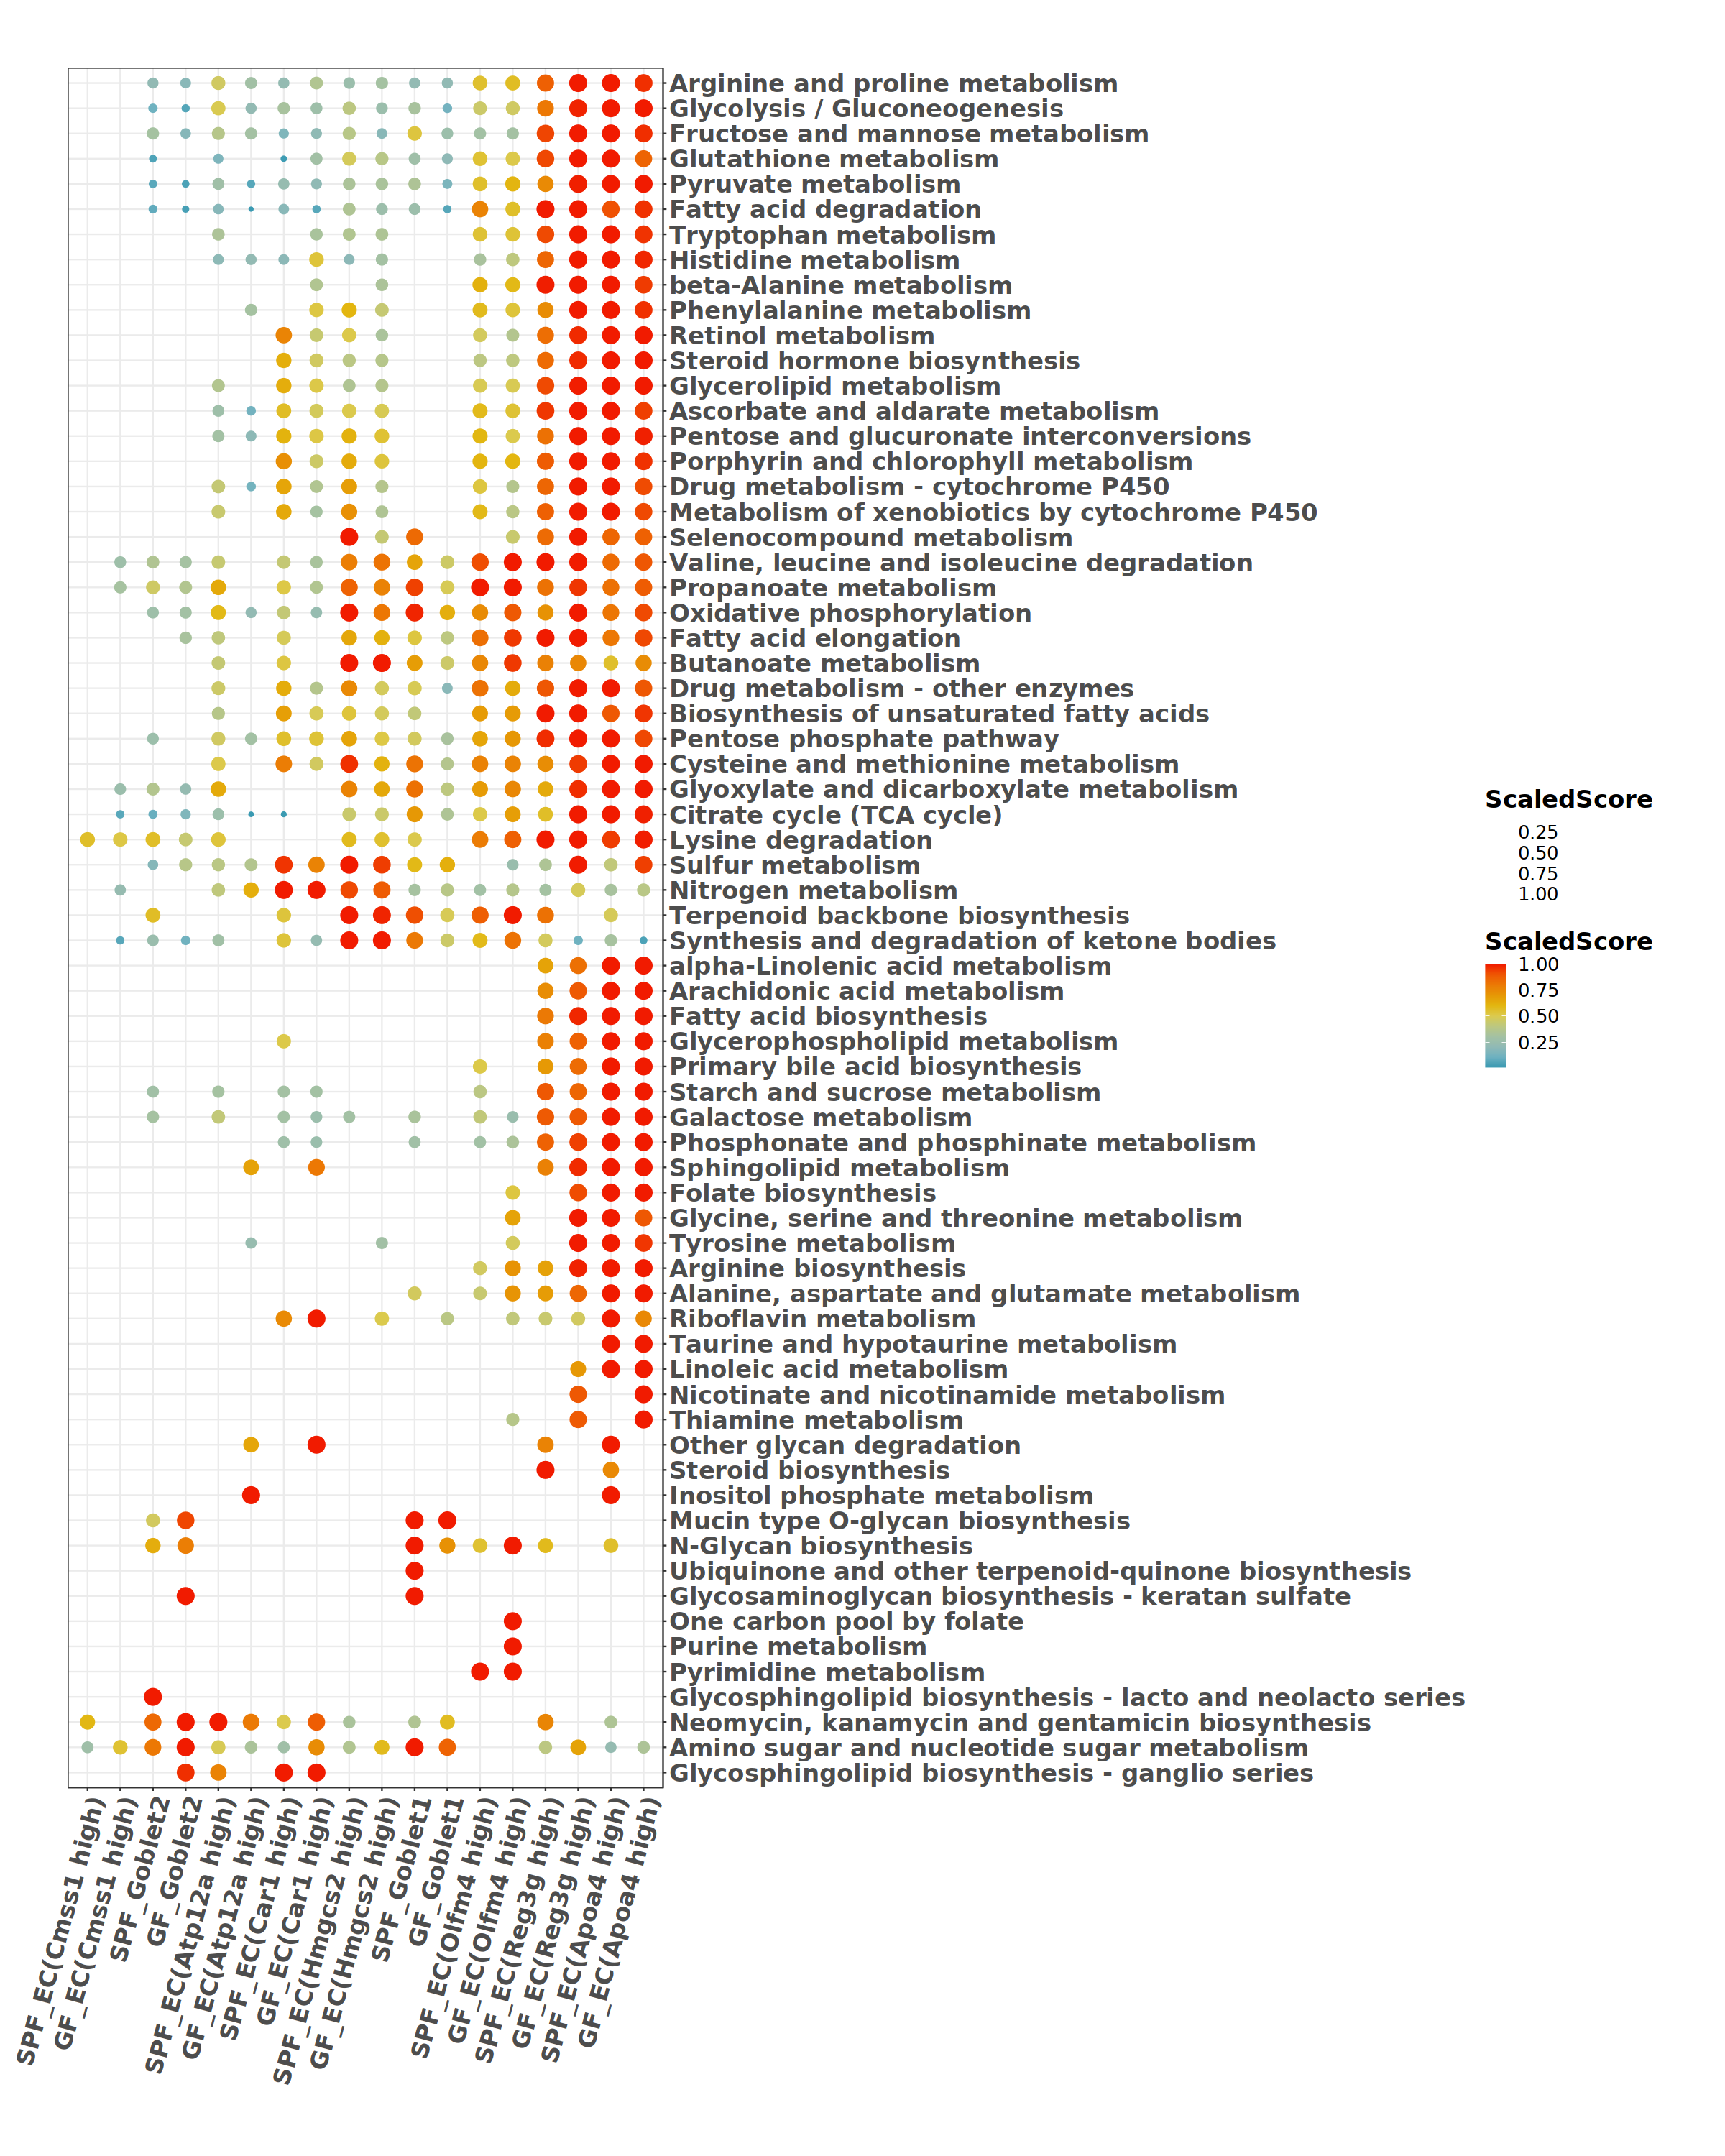

In [65]:
options(repr.plot.width = 20,repr.plot.height= 25)
bubbleplot_custom(df_long = df)

Warning message in wilcox.test.default(c(0.0583798247416077, 0.158441378001357, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.218404217095775, 0.00849667746691121, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.274430346427122, 0.540950960066875, 0.517889608234961, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.258504462334483, 0.449919227182873, 0.515508516935923, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.122614267290577, 0.345623682077428, 0.322932676662022, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.464288745338851, 0.682714743958893, 0.701450764751576, :
“cannot compute exact p-value with ties”


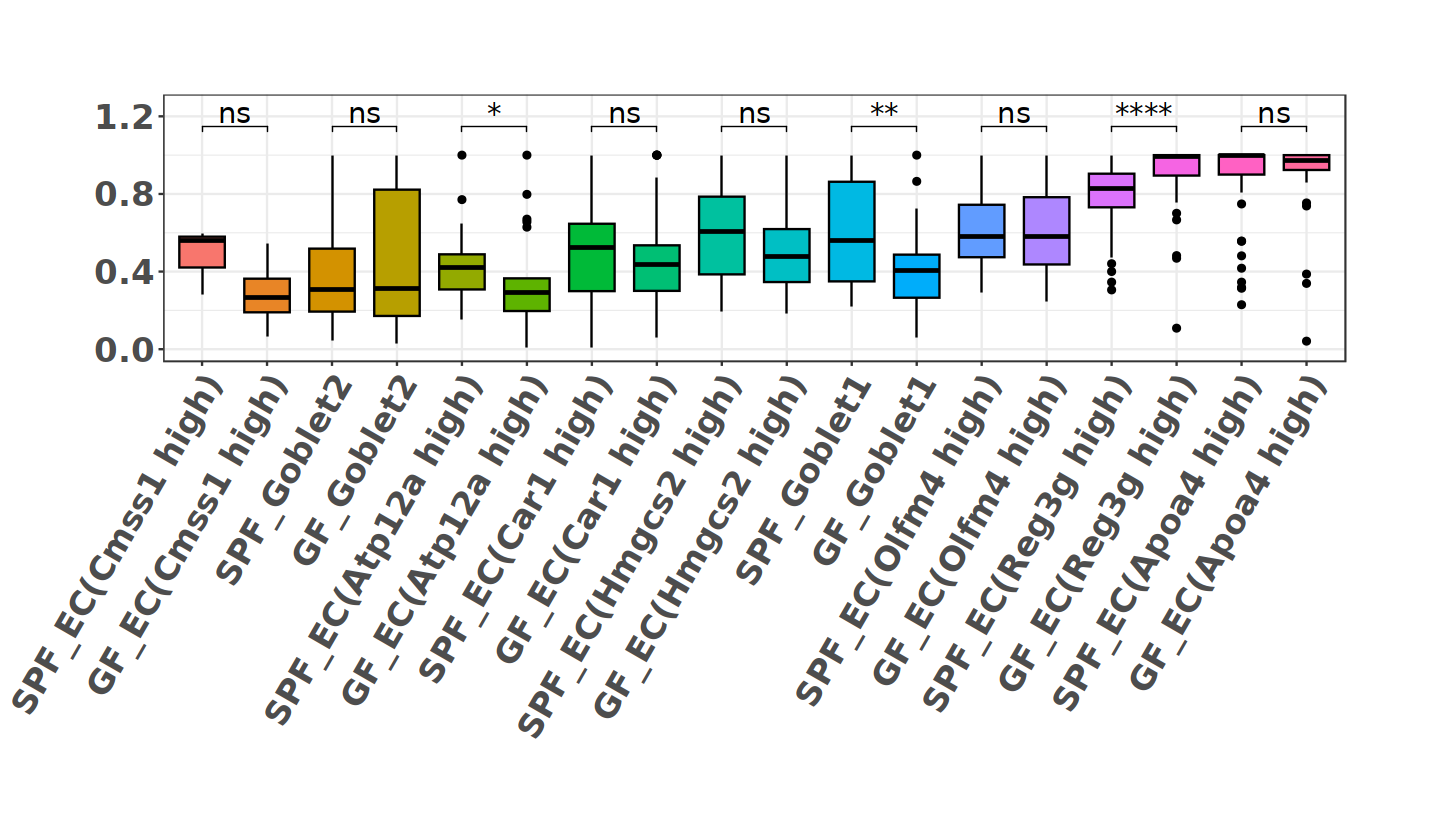

In [68]:
options(repr.plot.width = 12,repr.plot.height= 7)
my_comparisons <- list(c("GF_EC(Apoa4 high)","SPF_EC(Apoa4 high)"),
                       c("GF_EC(Reg3g high)","SPF_EC(Reg3g high)"),
                       c("GF_EC(Olfm4 high)","SPF_EC(Olfm4 high)"),
                       c("GF_Goblet1","SPF_Goblet1"),
                       c("GF_EC(Hmgcs2 high)","SPF_EC(Hmgcs2 high)"),
                       c("GF_EC(Car1 high)","SPF_EC(Car1 high)"),
                       c("GF_EC(Atp12a high)","SPF_EC(Atp12a high)"),
                       c("GF_Goblet2","SPF_Goblet2"),
                       c("GF_EC(Cmss1 high)","SPF_EC(Cmss1 high)"))
ggboxplot_custom(df_long =df,my_comparisons)

Figure 4F

In [33]:
GetLegendMax <- function(olst,gene){
    LM <- list()
    for(i in names(olst)){
        rds <- NormalizeData(olst[[i]])
        dat <- FetchData(rds,var = gene)
        print(max(dat[,gene]))
        LM[[i]] <- max(dat[,gene])
    }
    legend.max <- max(LM[[1]],LM[[2]]) + 0.5       
    return(legend.max)
}
TransformAngle <- function(data,angle){
    pi.tf <- pi * (angle / 180)
    mat.raw <- as.matrix(data.frame(data$x,data$y))
    mat.tf <- matrix(c(cos(2*pi.tf),sin(2*pi.tf),-sin(2*pi.tf),cos(2*pi.tf)),nrow = 2,ncol = 2)
    mat.fil <- mat.raw %*% mat.tf
    data$old_x <- data$x
    data$old_y <- data$y
    data$x <- mat.fil[,1]
    data$y <- mat.fil[,2]
    return(data)
}
plot_gene_3_spacial <- function(object,prefix,gene,transform,angle,title,legend.max,pt.size=0.05){ 
    P=list()
    dat=FetchData(object,vars=c(gene,"x","y"),slot="data")
    exp <- max(dat[,1])
    if(transform){
        dat <- TransformAngle(data = dat,angle = angle)
        dat <- dat[,-c(-1,-2,-3)]
    }else{
        print("No transform!")
    }
    len=dim(dat)[2]-2
    if(len>=1){
        for(i in 1:len){
            g <- colnames(dat)[i]
            cat(paste(g," max expression: ",exp,sep = ""),"\n")
            pl=ggplot(dat,aes_string(x = 'x',y = 'y',color = colnames(dat)[i])) + 
            #scale_color_gradient(low="white",high="darkred") +
            scale_color_gradient(low="white",high="red",limit = c(0,legend.max)) +
            geom_point(shape = 19, size = pt.size,position = position_jitter(width=0, height=0)) +
            #geom_jitter(width=2000,height=2000)
            dark_theme_bw() +
            dark_theme_void() +
            theme(axis.text = element_blank(), axis.ticks = element_blank(), panel.grid = element_blank(),
                    axis.title = element_blank(), axis.line = element_blank(), legend.position = 'right') +
            coord_fixed()+ 
            theme(legend.title = element_text(size = 25,family = "Times",face = "bold"))+
            theme(legend.text = element_text(size = 18,family = "Times",face = "bold")) +
            theme(plot.margin = unit(c(1,0.5,1,0.5),"cm")) + 
            ggtitle(title) +
            theme(plot.title =element_text(size = 30,family = "Times",face = "bold",hjust = 0.5))
            pl <- pl + annotate("segment",x = max(dat$x), xend = max(dat$x) - 200,
                                y = min(dat$y)-300,yend = min(dat$y)-300,size = 1)
            
            hjust = 0.7 # h = 0.5
            pl <- pl + annotate("text",x = max(dat$x) - 200,y = min(dat$y)-160,size = 6,
                                label = "100 μm",vjust = 0.5,hjust = hjust)

        }      
    }else{
        cat("The",gene,"is not existing. Please give up it from your input!\n")
        
    }
    return(pl)
}

In [34]:
GF_ileum1 <- readRDS("/data/work/04_SpatialRds/GF_ileum1.bin20.rds")
SPF_ileum1 <- readRDS("/data/work/04_SpatialRds/SPF_ileum3.bin20.rds")
rlst <- list(GF = NormalizeData(GF_ileum1),SPF = NormalizeData(SPF_ileum1))

In [35]:
lg.max = GetLegendMax(rlst,gene = "Reg3b")

[1] 5.948467
[1] 7.562202


In [36]:
plst <- list()
for(i in names(rlst)){
    print(i)
    plst[[i]] <- plot_gene_3_spacial(object = rlst[[i]],prefix=i,gene  = "Reg3b",
                                     legend.max = lg.max,transform = TRUE,angle = 15,title = i)
}

[1] "GF"
Reg3b max expression: 5.94846728501074 


Inverted geom defaults of fill and color/colour.
To change them back, use invert_geom_defaults().



[1] "SPF"
Reg3b max expression: 7.56220161123565 


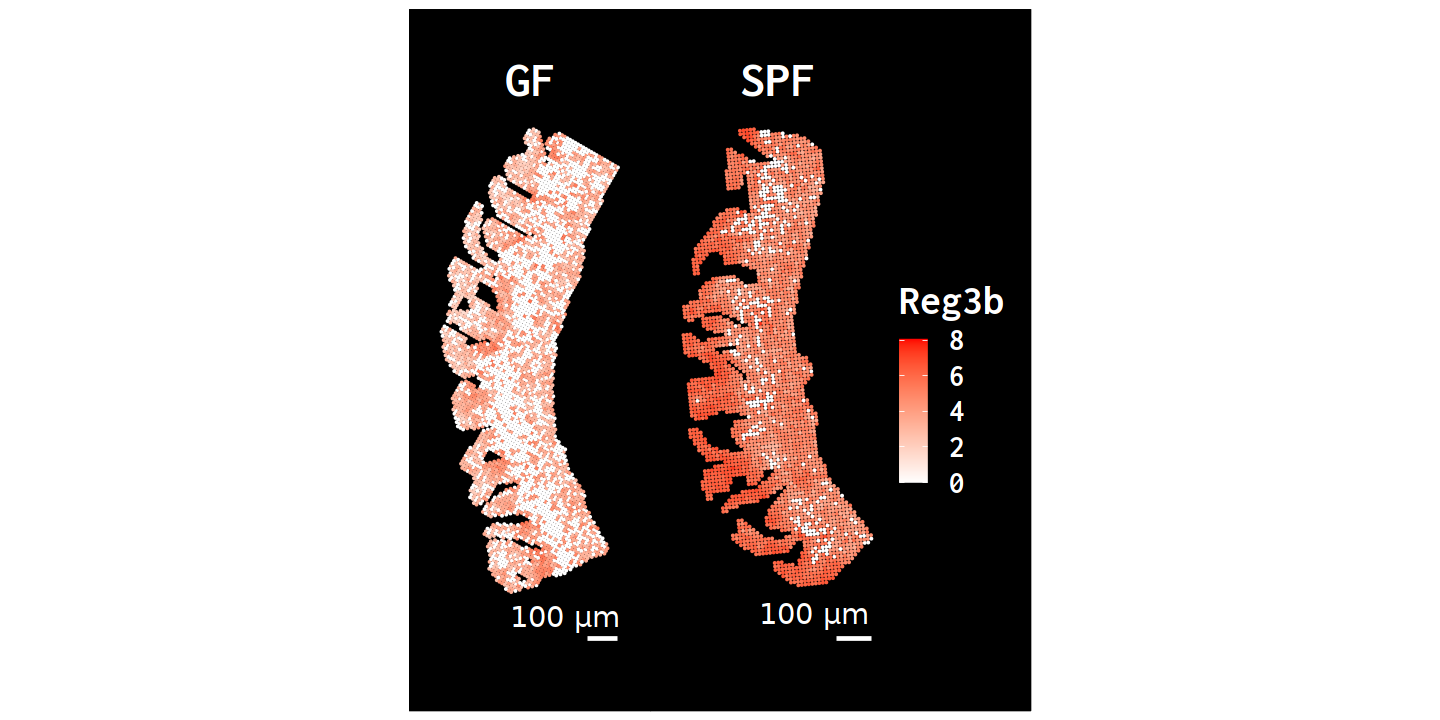

In [38]:
options(repr.plot.width =12,repr.plot.height= 6)
wrap_plots(plst,ncol=2)  + plot_layout(guides = 'collect')